# Dashmote Case Study

The analysis should focus on the following elements:

1. Discovering insights at a global level
2. Discovering insights at hairstyle level
3. Explore the relationships in between the hashtags used in the posts
4. Additionally, if you would have more time, what other types of analysis you would do?

### Load the required packages

In [ ]:
library(dplyr)
library(ndjson)
library(lubridate, warn.conflicts = F)
library(stringr)
library(ggplot2)
library(RColorBrewer)
library(tidytext)
library(tidyr)
library(widyr)
library(igraph)
# library(ggraph)

### Pre-process the data

In [2]:
# Set base path
path = "/media/yeachan153/bbf514ca-a0e5-45d1-8657-fa6fe2069d5c6/yeachan153/Desktop/Dashmote"
setwd(path)

# Load JSON file
df = stream_in("Data/Dashmote_data_set_case.json") 

# Change dtypes to int for comments & likes and datetime for unix 
df =
  df %>%
  mutate(comments = as.integer(comments),
         likes = as.integer(likes),
         date_unix = as_datetime(as.integer(date_unix))) 

# Remove hastags from tags
df = 
  df %>%
  rowwise() %>%
  mutate_at(vars(starts_with("hashtags")), 
            str_replace, 
            pattern = "#", 
            replacement = "") %>%
  ungroup()

# Add influencer_flag manually since it wasn't in the data file
#   - Reorder columns too
df = 
  df %>%
  mutate(inf_flag = ifelse(likes >= 500, T, F)) %>%
  select(user_id, id, inf_flag,
         cluster:date_week,
         likes, url,
         everything(), -hashtags)

# Only 1 user is categorised as an "influencer".
influencer_id = 
  df %>%
  filter(inf_flag == T) %>%
  .$user_id

# Remove influencers from the dataframe - unwanted variable
df = 
  df %>%
  filter(user_id != influencer_id)

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

Here's what the data looks like now after the pre-processing steps:

In [3]:
head(df, 2)

user_id,id,inf_flag,cluster,comments,date_formated,date_month,date_unix,date_week,likes,⋯,hashtags.54,hashtags.55,hashtags.56,hashtags.57,hashtags.58,hashtags.59,hashtags.60,hashtags.61,hashtags.62,hashtags.63
2963637811,BOuvqVnA8or,FALSE,buzzcut,19,01-01-2017,01,2017-01-01 17:37:18,52,269,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2897380111,BOuxiZXBee-,FALSE,chignon,38,01-01-2017,01,2017-01-01 17:53:42,52,222,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Discovering insights at a global level

On the global level, we can look at:

1. The statistical difference in the number of likes over the 3 different date points 
2. Number of likes over a 24 hour period

I focus on "likes" to limit the number of analyses. They also reflect the most popular medium of interaction with Instagram posts. There are usually far fewer comments.

### Difference in the number of likes over the 3 different date points

In [4]:
unique_dates = unique(df$date_formated)

print(sprintf("The three unique date points are: %s", 
              paste(unique(df$date_formated), collapse = ", ")))

[1] "The three unique date points are: 01-01-2017, 01-02-2017, 01-03-2017"


#### One way ANOVA
We can use a one way ANOVA to investigate if the difference in the mean number of likes is statistically different over the 3 different time periods.

In [5]:
# Factor the 3 unique dates and select only the data we want
likes_date = 
  df %>%
  mutate(date_group = ifelse(date_formated == unique_dates[1],
                             1, 
                      ifelse(date_formated == unique_dates[2],
                             2,
                      ifelse(date_formated == unique_dates[3],
                             3,
                             NA))),
         date_group = factor(date_group, levels = c(1, 2, 3),
                             labels = unique_dates)) %>%
  select(likes, date_group)

In [6]:
likes_anova = aov(likes ~ date_group, data = likes_date)
summary(likes_anova)

              Df   Sum Sq Mean Sq F value Pr(>F)    
date_group     2   495639  247820   63.68 <2e-16 ***
Residuals   9996 38900897    3892                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [7]:
TukeyHSD(likes_anova)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = likes ~ date_group, data = likes_date)

$date_group
                            diff        lwr         upr     p adj
01-02-2017-01-01-2017  -3.365062  -6.860029   0.1299051 0.0620829
01-03-2017-01-01-2017 -18.933135 -23.162782 -14.7034882 0.0000000
01-03-2017-01-02-2017 -15.568073 -19.302006 -11.8341411 0.0000000


The results suggest that images posted on Feb 1st and Jan 1st received a similar number of likes. However, images posted on the March 1st received significantly less likes than ones posted in February or January.

#### Visualising differences

It's always easier to see these differences visually.

Warning message:
“Removed 641 rows containing non-finite values (stat_boxplot).”

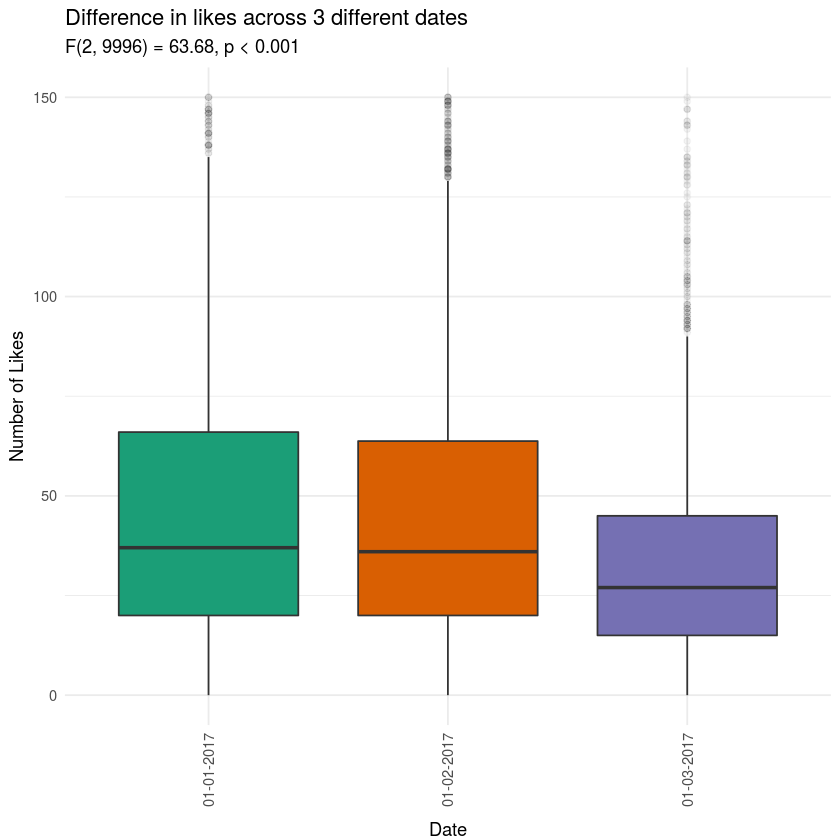

In [8]:
# Visualising differences
hex_codes = brewer.pal(3, "Dark2") # Balanced hues for categorical differences

th = theme(
  axis.text.x = element_text(angle = 90, vjust = 0.5),
  axis.title.x = element_text(vjust = -1)
)

likes_date %>%
  ggplot(aes(x = date_group, y = likes)) +
  geom_boxplot(fill = hex_codes,
               outlier.alpha = 0.05) +
  scale_y_continuous(limits = c(0, 150)) +
  labs(x = "Date",
       y = "Number of Likes",
       title = "Difference in likes across 3 different dates",
       subtitle = "F(2, 9996) = 63.68, p < 0.001") +
  theme_minimal() +
  th

### Number of likes over a 24 hour period

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

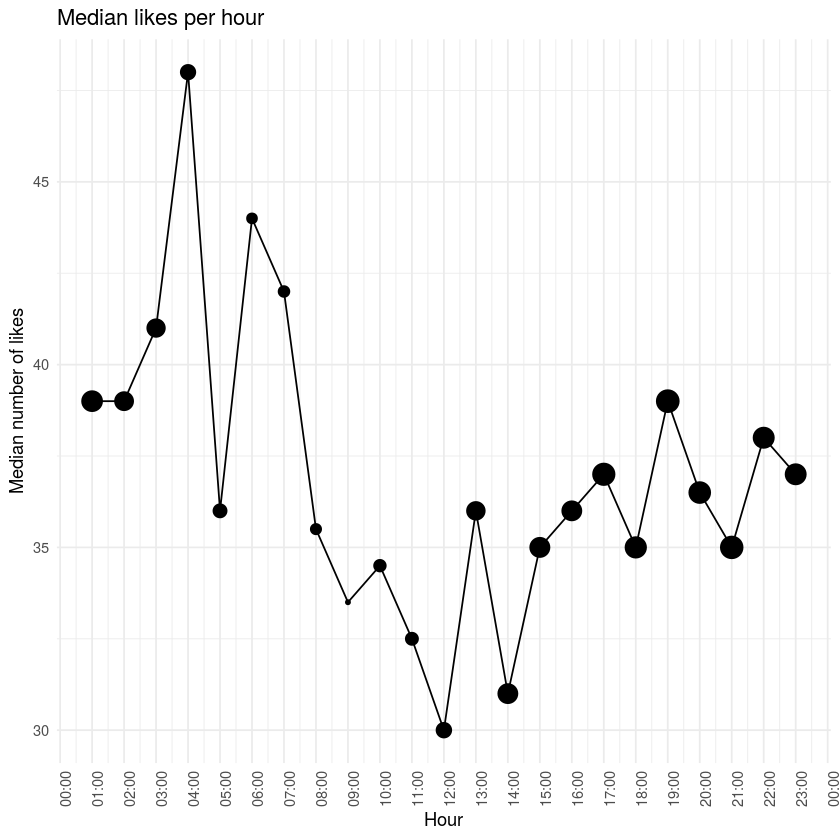

In [9]:
# Number of likes over 24 hours - extract time, add artificial date
time_likes =
  suppressWarnings(
    df %>% 
    select(likes, date_unix) %>%
    mutate(hour = hour(date_unix),
           minute = minute(date_unix),
           second = second(date_unix),
           time = str_c(hour, minute, second, sep = ":"),
           time = hms(time),
           fake_date_time = ymd_hms(str_c(today(), time))) %>%
    select(likes, fake_date_time))

# Take hourly average to smooth data points
time_likes_2 =
  time_likes %>%
  group_by(per_hour = floor_date(fake_date_time, unit = "hour")) %>%
  mutate(med_likes = median(likes),
         count = n()) %>%
  slice(1) %>%
  ungroup() %>%
  select(per_hour, med_likes, count)

# Plot time graph
th2 = theme(
  axis.text.x = element_text(angle = 90),
  legend.position = "none"
)

time_likes_2 %>%
  ggplot(aes(x = per_hour, y = med_likes)) +
  geom_line() +
  geom_point(aes(size = count)) +
  scale_x_datetime(date_label = "%H:%M", date_breaks = "1 hour") + 
  labs(x = "Hour",
       y = "Median number of likes",
       title = "Median likes per hour") +
  theme_minimal() +
  th2

What can we tell from this graph? It's difficult to draw any conclusions because there's no information in the data that tells us what time zones these instagram posts were made in. Even if we make the assumption that the data is from one time frame, it doesn't make sense to infer too much from data across 3 days. 

The size of the points refer to how many posts were made during that hour. We can see a lot of posts were made from around 12:00 - 02:00. Interesting to see that the highest median likes came at between 03:00 - 07:00, even though not many users were posting images.

## Discovering insights at hairstyle level

We can grab sentiment score and visualise it for the top 4 most posted about clusters on Instagram. We can plot this at 3 different time points:

1. 01/01/17
2. 01/02/17
3. 01/03/17

In [10]:
# Discovering insights at hairstyle level
top_4_hair = 
  df %>%
  group_by(cluster) %>%
  count() %>%
  arrange(desc(n)) %>%
  ungroup() %>%
  slice(1:4) %>%
  .$cluster

# We only explore data for the top 4 hairstyles
top_4_df = 
  df %>%
  filter(cluster %in% top_4_hair)

# Concatnate all hashtags
temp_top_4_df = 
  top_4_df %>%
  select(cluster, date_formated, contains("hashtags")) %>%
  mutate(date_formated = dmy(date_formated)) %>%
  unite(hashtags, 
        top_4_df %>% 
          select(contains("hashtags")) %>% 
          colnames(),
        sep = ", ")
  
# Remove NA's from concatnated hashtags and whitespaces
temp_top_4_df =
  temp_top_4_df %>%
  mutate(hashtags = str_remove_all(hashtags, "NA,|NA"),
         hashtags = str_replace_all(hashtags, " ", ""))

# Get into tidy text format
tidy_top_4 =
  temp_top_4_df %>%
  unnest_tokens(word, hashtags)

# Remove stop words
tidy_top_4 = 
  tidy_top_4 %>%
  anti_join(stop_words)

# Get sentiment score
sentiment_scores = 
  tidy_top_4 %>%
  inner_join(get_sentiments("afinn")) 

Joining, by = "word"
Joining, by = "word"


Now we can plot sentiment scores over the 3 months and assess how people's feelings changed towards the hairstyles.

In [12]:
# Get colors
hex_codes = brewer.pal(4, "Dark2")

# Define another theme
th3 = theme(
  axis.text.x = element_text(angle = 90, vjust = 0.5),
  axis.title.x = element_text(vjust = -1),
  legend.justification = "top"
)

# Sentiment score boxplot
sentiment_boxplot =
  sentiment_scores %>%
  mutate(date_formated = factor(date_formated, levels = c("2017-01-01",
                                                          "2017-02-01",
                                                          "2017-03-01"))) %>%
  ggplot(aes(x = date_formated, y = score)) +
  geom_boxplot(aes(fill = cluster), outlier.alpha = 0.1) +
  labs(x = "Date",
       y = "Sentiment Score",
       title = "Sentiment score across 3 time periods") +
  scale_fill_discrete(name = "Cluster/Hairstyle Type") +
  scale_y_continuous(limits = c(-5, 5)) +
  theme_minimal() +
  th3 +
  scale_fill_manual(values = hex_codes)

# Number of posts that sentiment dictionary could identify
num_posts = 
  sentiment_scores %>%
  mutate(date_formated = factor(date_formated, levels = c("2017-01-01",
                                                          "2017-02-01",
                                                          "2017-03-01"))) %>%
  group_by(date_formated, cluster) %>%
  count() %>% 
  ggplot(aes(x = date_formated, y = n, group = cluster)) +
  geom_point(aes(color = cluster), stat='summary', fun.y = sum) +
  stat_summary(aes(color = cluster), fun.y = sum, geom = "line") +
  theme_minimal() + 
  th3 +
  scale_color_manual(values = hex_codes) +
  labs(x = "Date",
       y = "Number of posts identified",
       title = "Number of images included in sentiment analysis per date") 

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


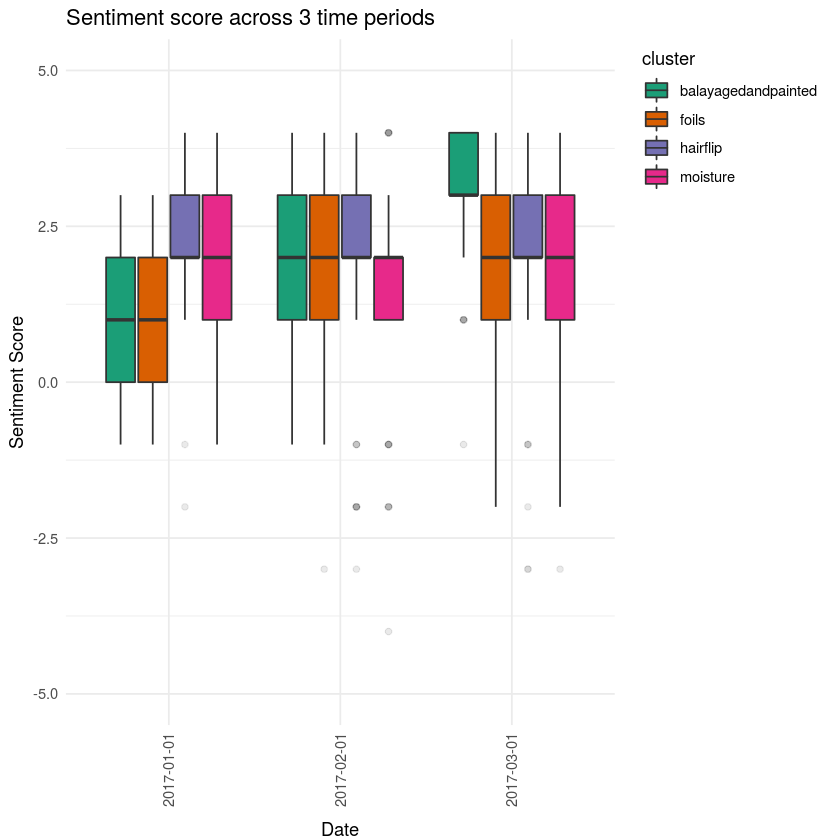

In [13]:
sentiment_boxplot

It looks like the sentiment for the "balay aged and painted" style went up across the time points. Perhaps it is worth investigating further to check if this is going to be trending in the future. All the other hairstyles seem to be relatively stable in popularity.

However, we should check how many hashtags per cluster were identifiable as a sentiment. 

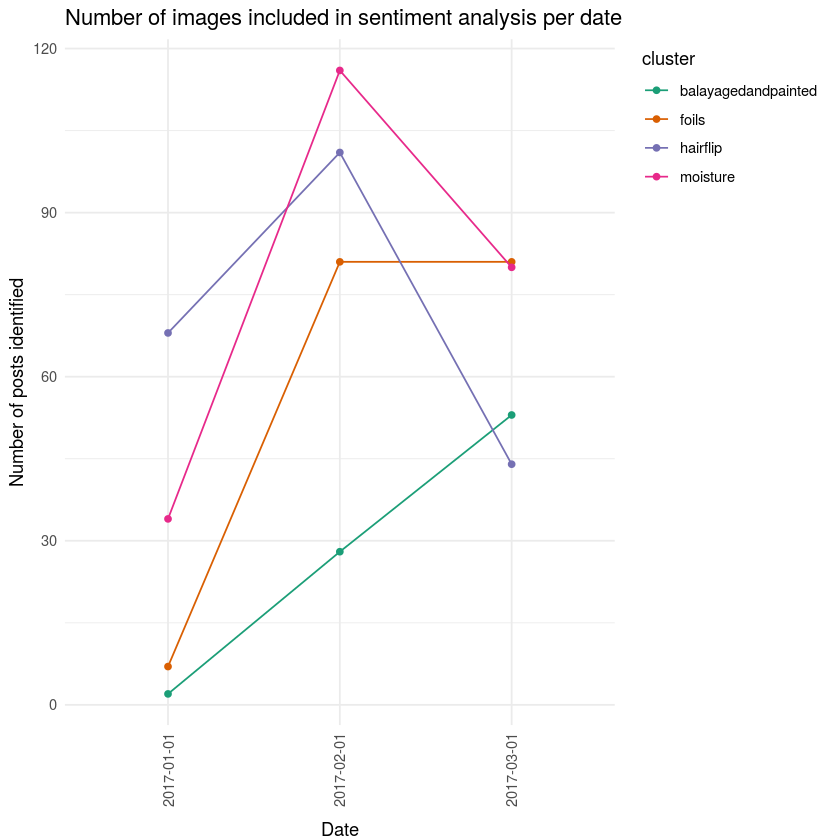

In [14]:
num_posts

Once we check how many hashtags per cluster were identifiable as a sentiment, we find that the large majority of hashtags were not matched by the sentiment dictionary. Therefore, our results might not be as reliable as we like. For example, it looks like we only had two 'sentiment' words for 'balay aged and painted' on 01/01/2017.

## Explore the relationships in between the hashtags used in the posts

We can visualise which hashtags were correlated with each other, and examine which hashtags occured most frequently.

In [22]:
# Concatnate all hashtags
concat_hashtags =
  df %>%
  select(id, contains("hashtags")) %>%
    unite(hashtags, 
          df %>% 
          select(contains("hashtags")) %>% 
          colnames(),
        sep = ", ")

# Remove NA's from concatnated hashtags and whitespaces
concat_hashtags =
  concat_hashtags %>%
  mutate(hashtags = str_remove_all(hashtags, "NA,|NA"),
         hashtags = str_replace_all(hashtags, " ", ""))

# Get into tidy text format
concat_hashtags_tidy =
  concat_hashtags %>%
  unnest_tokens(word, hashtags)

# Remove stop words and lower case every word
hashtags_tidy =
  concat_hashtags_tidy %>%
  anti_join(stop_words) %>%
  mutate(word = tolower(word))

Joining, by = "word"


#### Which hashtags occur most often?

In [31]:
hashtags_tidy %>% 
    count(word, sort = T) %>%
    print(n = 10)

# A tibble: 33,931 x 2
   word               n
   <chr>          <int>
 1 hair            1423
 2 balayage         958
 3 behindthechair   747
 4 modernsalon      737
 5 blonde           685
 6 hairstyle        640
 7 foils            639
 8 hairstylist      573
 9 haircolor        553
10 braids           480
# ... with 3.392e+04 more rows


#### Which hashtags are most correlated with each other?

In [32]:
# Get hashtags that are correlated together
hashtag_cor = 
  hashtags_tidy %>% 
  group_by(word) %>%
  filter(n() >= 100) %>%
  pairwise_cor(word, id, sort = TRUE, upper = FALSE)

head(hashtag_cor, 20)

Warning message:
“Trying to compute distinct() for variables not found in the data:
- `row_col`, `column_col`
This is an error, but only a warning is raised for compatibility reasons.
The operation will return the input unchanged.”

item1,item2,correlation
behindthechair,modernsalon,0.6885481
retro,retrohair,0.6432400
retro,pinup,0.6339816
americansalon,modernsalon,0.6328092
vintagehair,pinup,0.6086169
retro,vintage,0.6035126
retrohair,vintagehair,0.5523894
retrohair,pinup,0.5390676
behindthechair,americansalon,0.5389930
cute,slay,0.5354835


Here, we can see the top 20 hashtags that are correlated together along with the strength of the correlation. We can visualise this. 

**Unfortunately**, a package I need to do this *ggraph* failed to install on my Jupyter R Kernal so I have run it on another platform and will attach the results as an image. I've attached the code to make the graph below:

In [ ]:
hashtag_cor %>%
  filter(correlation > .3) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation, edge_width = correlation), edge_colour = "royalblue") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE,
                 point.padding = unit(0.2, "lines")) +
  theme_void()

![Cor plot](Rplot01.png)

It looks like many hashtags are connected, and occur in the presence of other hashtags. For example, there's a very distinct vintage hashtag cluster (bottom right).

## Additionally, if you would have more time, what other types of analysis you would do?

I would like to also try visualising hashtags by using co-occurence rather than correlation. This might reveal different clusters of structures form which we can gain other insights.

## Pipeline
In the above situation you have been provided with a dataset based upon images. Imagine the situation in which you would need to source the information from an online source. Describe the data pipeline you would build in order to reach a similar result.

Assuming I have a list of URLs to download the images from, I would create a script which downloads these images and stores them in some kind of cloud storage like an S3 bucket. I would then place this script in an automation server like Jenkins as a job to run however frequently it needs to run. After we have the images in the S3 bucket, we can have another script put into Jenkins that runs whatever image-classification algorithm it needs to server side. If we need more power (e.g. a better GPU), we could use cloud computing services (e.g. EC2). 

## Premium photography identification
Professional photographers are a distinct group of creatives. Their work is highly subjective
and only by using human intuition we are able to classify them. How would you use visual
recognition in order to separate professional photographers from amateurs ones?
Note: describe what steps you would take in order to answer the question and what possible
elements of professional photographers you would take into consideration.

It depends how many images I have to work with and how well the images were taken. If we have only relatively few images (e.g. under 500 images from each group), I would be tempted to try a quick transfer learning approach. 

I'd take a pre-trained convolutional neural network (CNN) without the final layer and freeze the rest, perform image augmentation (to train for more epochs without overfitting), and train a new dense layer on top (with sigmoid activation) and see the results. I'd try this for multiple model architectures (e.g. ResNet, NASNet). If we had more images, you could unfreeze the last few layers of the CNN and see if a fine-tuning approach can improve accuracy over a feature extraction method.

I did something similar for my previous internship using Keras:
https://colab.research.google.com/drive/1_i6Pka_spZghFHZc0zY20t4OT_2T7w--